In [1]:
import numpy as np
from scipy import integrate
import scipy.signal
import scipy
# import ot
import math
from tifffile import tifffile

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time

from measure_3d import*
from Homotopy_Boosted_SFW_KL_3D import*
from Homotopy_Boosted_SFW_L2_3D import*

In [2]:
sigma = 200 # PSF spread factor on xy
sigma_z = 2*sigma # PSF spread factor on z
sigma_noise = 1e-3 # Sigma for the Gaussian noise
noise_level = 20 # Poisson noise

N_xy = 40 #grid x-y plane
N_z = 8 #z slices
pixel_size_xy = 65
pixel_size_z = 250
sizeGrid_xy = N_xy * pixel_size_xy
sizeGrid_z = N_z * pixel_size_z

X,Y,Z = np.meshgrid(np.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy),
                   np.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy),
                   np.linspace(-sizeGrid_z/2,sizeGrid_z/2, N_z))


bg_gt = 0.5
# m_ax0 = rand_gt(sizeGrid_xy, sizeGrid_z, pixel_size_xy, pixel_size_z, 7, 250)
# y0 = m_ax0.kernel(X,Y,Z,sigma, sigma, sigma_z)
# y = m_ax0.acquisition(X, Y, Z, N_xy, N_z,sigma, sigma, sigma_z, bg, noise_level, noiseType='Poisson') + 1e-8


In [3]:
x_gt = [[  210,  -284,     9],
       [ -640,   174,   314],
       [  123,   362,   609],
       [  288,  -318,   619],
       [  520,  -107,  -513],
       [  181, -1048,  -394],
       [  410,   562,  -366]]
a_gt = [1.11687685, 0.91494509, 1.24776664, 0.70993561, 1.29997242,
       0.90754208, 1.17418891]

m_ax0 = Measure3D(a_gt, x_gt)

y0 = m_ax0.kernel(X,Y,Z,sigma, sigma, sigma_z)
y = m_ax0.acquisition(X, Y, Z, N_xy, N_z,sigma, sigma, sigma_z, bg_gt, noise_level, noiseType='Poisson') + 1e-8

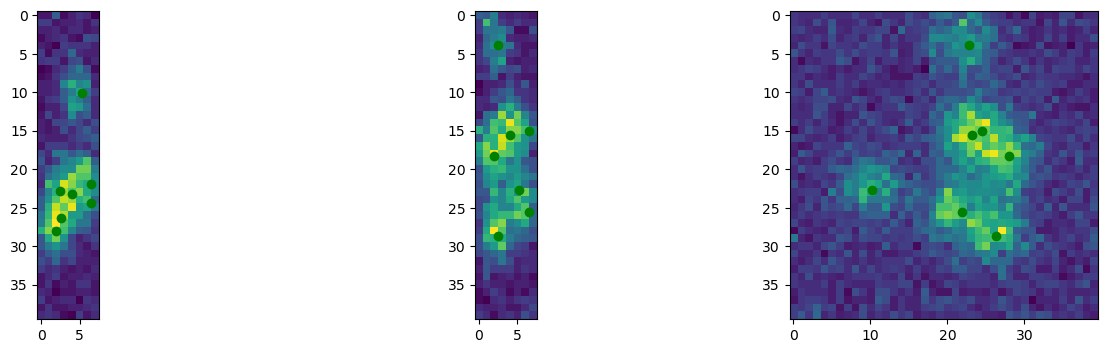

In [4]:
plt.figure(figsize=(16, 4))
for i in range(3): 
    plt.subplot(1,3,i+1)
    plt.imshow(np.amax(y[:,:,:],axis=i))
    if i == 0:
        plt.scatter(m_ax0.x[:,2]/pixel_size_z+N_z/2, m_ax0.x[:,0]/pixel_size_xy+N_xy/2, c='green')
    elif i == 1:
        plt.scatter(m_ax0.x[:,2]/pixel_size_z+N_z/2, m_ax0.x[:,1]/pixel_size_xy+N_xy/2, c='green')        
    else: 
        plt.scatter(m_ax0.x[:,0]/pixel_size_xy+N_xy/2, m_ax0.x[:,1]/pixel_size_xy+N_xy/2, c='green')
plt.show()

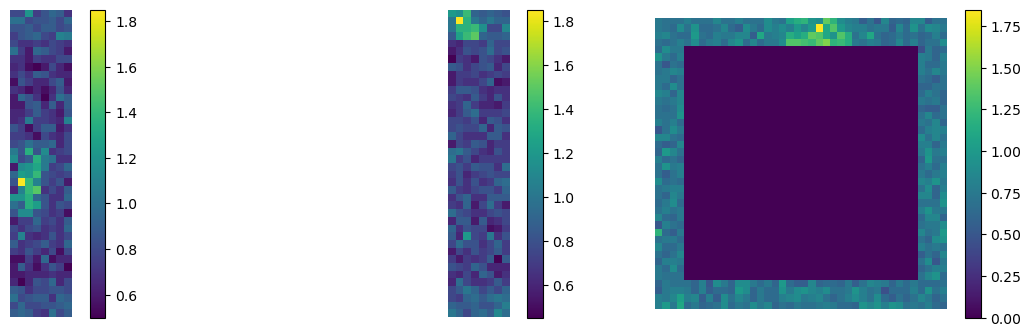

In [5]:
# Create a new array with the same shape and dtype
outer_part = np.zeros_like(y)

#outer_crown = np.zeros_like(y)
outer_part[:4, :, :] = y[:4, :, :]  # Prime 4 righe
outer_part[36:, :, :] = y[36:, :, :]  # Ultime 4 righe
outer_part[4:36, :4, :] = y[4:36, :4, :]  # Prime 4 colonne (parte centrale esclusa)
outer_part[4:36, 36:, :] = y[4:36, 36:, :]  # Ultime 4 colonne (parte centrale esclusa)

plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.imshow(np.amax(outer_part[:,:,:],axis=0))
plt.ylabel('x')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.amax(outer_part[:,:,:],axis=1))
plt.ylabel('y')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.amax(outer_part[:,:,:],axis=2))
plt.ylabel('y')
plt.xlabel('x')
plt.colorbar()
plt.axis('off')
plt.show()

non_zero_elements = outer_part[outer_part != 0]
mean_of_non_zero = np.mean(non_zero_elements)

# background
bg = mean_of_non_zero

In [6]:
# compute D_kl over the background
m = Measure3D([],[])
aus = m.kernel(X, Y, Z, sigma, sigma, sigma_z)
aus = aus[outer_part != 0]
sigma_noise_bg_KL = np.sum(aus+bg-non_zero_elements+non_zero_elements*np.log(non_zero_elements) - non_zero_elements*np.log(aus+bg))

sigma_target_bertero = np.shape(y)[0]*np.shape(y)[1]*np.shape(y)[2]/2
sigma_target_KL = sigma_target_bertero*sigma_noise_bg_KL/non_zero_elements.shape[0]*2


# sigma_noise_bg_L2 = 0.5*my3dnorm(aus+bg-non_zero_elements)**2
aus2 = aus+bg-non_zero_elements
sigma_noise_bg_L2 = 0.5*np.sum(np.square(aus2))

sigma_target_L2 = sigma_target_bertero*sigma_noise_bg_L2/non_zero_elements.shape[0]*2

In [26]:
bg

0.5149088641666667

In [7]:
iteration = m_ax0.N+1

# sigma_target_KL = 1.1*KLTV_cost_funct(m_ax0, y, bg,  X, Y, Z, sigma, sigma, sigma_z, 0)

(m_sfw_KL, energy_sfw_KL, lambda_sfw_KL) = Homotopy_Boosted_SFW_KULLBACK_3D(y, bg, sigma_target_KL, sigma, sigma, sigma_z, X, Y, Z, N_xy, N_z, 
                                      pixel_size_xy, pixel_size_z, m_0=0, nnIter=iteration, nIter=2, c=20,
                                                       BoostPar = 10, verbose = True, plots = True)

print('We reconstruct m_ax with positions: '); print(np.round(np.reshape(m_sfw_KL.x,-1),2))
print('and with amplitudes: '); print(np.round(np.reshape(m_sfw_KL.a,-1),2))
print('We want m_ax0 with positions: '); print(np.round(np.reshape(m_ax0.x,-1),2))
print('and with amplitudes: '); print(np.round(np.reshape(m_ax0.a,-1),2))

sigma_target = 375.7387373628566


*** Homotopy iteration n.0 ***
max of certificate=54.71807694836498
lambda=54.71807694836498
Certificate argmax = 5.0

*** Iteration n. 1 ***
Certificate argmax = 5.0
FRANK-WOLFE (NON SLIDING) STEP 
New position x^* = [325.0, -195.0, 0.0] max value of certificate 5.0
Measure_k : 
* x_k : [[ 325. -195.    0.]]
* a_k : [1.3557]
Pruning:
* x_k : [[ 325. -195.    0.]]
* a_k : [1.3557]
* Energy : 700.106

*** Iteration n. 2 ***
Certificate argmax = 3.4707254028749723
Sliding performed at the last iteration
FRANK-WOLFE (NON SLIDING) STEP 
New position x^* = [390.0, 520.0, -250.0] max value of certificate 3.4707
Measure_k : 
* x_k : [[ 325. -195.    0.]
 [ 390.  520. -250.]]
* a_k : [1.3073 0.7817]
Pruning:
* x_k : [[ 325. -195.    0.]
 [ 390.  520. -250.]]
* a_k : [1.3073 0.7817]
SLIDING STEP
Measure_k: 
* x_k : [[ 320.6433 -221.9443  -50.0227]
 [ 351.4297  475.9109 -151.8929]]
* a_k : [1.2864 0.8243]
Pruning:
* x_k : [[ 320.6433 -221.9443  -50.0227]
 [ 351

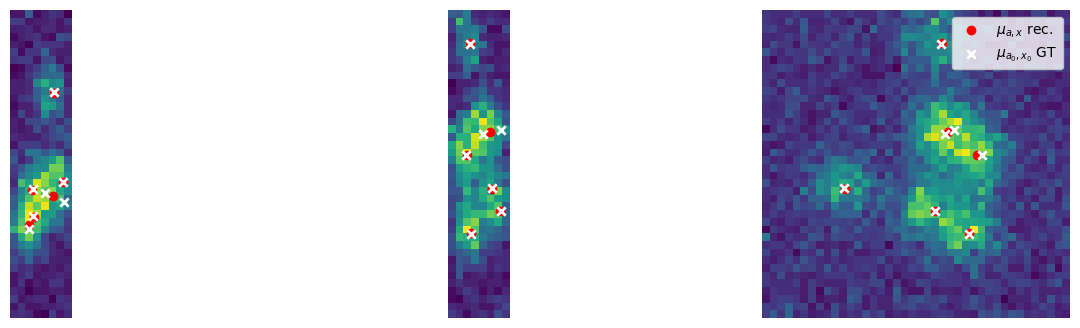

In [8]:
plt.figure(figsize=(16, 4))
for i in range(3): 
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.amax(y[:, :, :], axis=i))
    
    scatter_red = plt.scatter(
        m_sfw_KL.x[:, 2] / pixel_size_z + N_z / 2 if i != 2 else m_sfw_KL.x[:, 0] / pixel_size_xy + N_xy / 2,
        m_sfw_KL.x[:, 0] / pixel_size_xy + N_xy / 2 if i == 0 else m_sfw_KL.x[:, 1] / pixel_size_xy + N_xy / 2,
        c='red', label=r'$\mu_{a,x}$ rec.')
    
    scatter_white = plt.scatter(
        m_ax0.x[:, 2] / pixel_size_z + N_z / 2 if i != 2 else m_ax0.x[:, 0] / pixel_size_xy + N_xy / 2,
        m_ax0.x[:, 0] / pixel_size_xy + N_xy / 2 if i == 0 else m_ax0.x[:, 1] / pixel_size_xy + N_xy / 2,
        marker='x', color='white', label=r'$\mu_{a_0,x_0}$ GT', linewidths=2)
    
    if i == 2:
        plt.legend(loc='best', fontsize=10)
        
    plt.axis('off')

plt.show()


In [9]:
# q_xy = 10 # super-resolution factor
# q_z = 5
# sigma_q_xy = sigma/q_xy
# sigma_q_z = sigma_z/q_z

# X_big,Y_big,Z_big = np.meshgrid(np.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy*q_xy),
#                    np.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy*q_xy),
#                    np.linspace(-sizeGrid_z/2,sizeGrid_z/2, N_z*q_z))
# rec_KL = m_sfw_KL.kernel(X_big,Y_big,Z_big, sigma_q_xy, sigma_q_xy, sigma_q_z)

# plt.figure(figsize=(16, 4))
# for i in range(3): 
#     plt.subplot(1,3,i+1)
#     plt.imshow(np.amax(rec_KL[:,:,:],axis=i))
# plt.show()

In [35]:
tol = 3*pixel_size_xy
jaccard_KL, TP_KL, FN_KL, FP_KL, RMSE_ampl_KL, RMSE_pos_KL = jaccard_rmse(m_ax0, m_sfw_KL, tol)
jaccard_KL, TP_KL, FN_KL, FP_KL, RMSE_ampl_KL, RMSE_pos_KL

(0.625, 5, 2, 1, 0.11766875898545595, 22.079483546248564)

In [32]:
iteration = m_ax0.N+1

# sigma_target_L2 = L2TV_cost_funct(m_ax0, y, bg,  X, Y, Z, sigma, sigma, sigma_z, 0)

(m_sfw_L2, energy_sfw_L2, lambda_sfw_L2) = Homotopy_Boosted_SFW_L2_3D(y, bg, sigma_target_L2/10, sigma, sigma, sigma_z, X, Y, Z, N_xy, N_z, 
                                      pixel_size_xy, pixel_size_z, 
        m_0=0, nnIter=iteration, nIter=2, c=5, BoostPar = 10, verbose = True, plots = True, gt = m_ax0)

print('We reconstruct m_ax with positions: '); print(np.round(np.reshape(m_sfw_L2.x,-1),2))
print('and with amplitudes: '); print(np.round(np.reshape(m_sfw_L2.a,-1),2))
print('We want m_ax0 with positions: '); print(np.round(np.reshape(m_ax0.x,-1),2))
print('and with amplitudes: '); print(np.round(np.reshape(m_ax0.a,-1),2))



sigma_target = 19.697328016493056


*** Homotopy iteration n.0 ***
max of certificate=54.71807694836498
lambda=54.71807694836498
Certificate argmax = 2.5745443208333327

*** Iteration n. 1 ***
Certificate argmax = 2.5745443208333327
FRANK-WOLFE (NON SLIDING) STEP 
New position x^* = [325.0, -195.0, 0.0] max value of certificate 2.5745
Measure_k : 
* x_k : [[ 325. -195.    0.]]
* a_k : [2.6805]
Pruning:
* x_k : [[ 325. -195.    0.]]
* a_k : [2.6805]
* Energy : 161.061

*** Iteration n. 2 ***
Certificate argmax = 1.7649820344203249
Sliding performed at the last iteration
FRANK-WOLFE (NON SLIDING) STEP 
New position x^* = [390.0, 520.0, -250.0] max value of certificate 1.765
Measure_k : 
* x_k : [[ 325. -195.    0.]
 [ 390.  520. -250.]]
* a_k : [2.6066 2.0452]
Pruning:
* x_k : [[ 325. -195.    0.]
 [ 390.  520. -250.]]
* a_k : [2.6066 2.0452]
SLIDING STEP
Measure_k: 
* x_k : [[ 310.0804 -244.1562  -25.5008]
 [ 369.5638  501.9618 -188.9179]]
* a_k : [2.6176 2.0868]
Pruning:
* x_k : [[ 310

* a_k : [2.3715 2.4302 2.2831 2.5824 2.1313 1.9368 0.6905]
Pruning:
* x_k : [[  103.1651   378.2884   557.0254]
 [  439.5111   594.5739  -390.9086]
 [ -653.2457   175.5054   266.5842]
 [  516.2044  -113.3899  -496.1003]
 [  181.8921 -1013.8438  -362.0789]
 [  211.1495  -326.9339   329.4794]
 [  195.      -325.       250.    ]]
* a_k : [2.3715 2.4302 2.2831 2.5824 2.1313 1.9368 0.6905]
* Energy : 19.518

*** Iteration n. 2 ***
Certificate argmax = 546.2843135701576
Sliding performed at the last iteration
FRANK-WOLFE (NON SLIDING) STEP 
New position x^* = [195.0, -325.0, 250.0] max value of certificate 546.2843
Measure_k : 
* x_k : [[  103.1651   378.2884   557.0254]
 [  439.5111   594.5739  -390.9086]
 [ -653.2457   175.5054   266.5842]
 [  516.2044  -113.3899  -496.1003]
 [  181.8921 -1013.8438  -362.0789]
 [  211.1495  -326.9339   329.4794]
 [  195.      -325.       250.    ]
 [  195.      -325.       250.    ]]
* a_k : [2.3715 2.4302 2.2831 2.5824 2.1313 1.9368 0.6905 0.    ]
Pruning

* a_k : [2.3441 2.4442 2.2695 2.4234 2.1296 1.969  1.3468 1.8247 0.    ]
Pruning:
* x_k : [[  112.2915   367.5406   603.1289]
 [  413.4552   606.0744  -409.3873]
 [ -650.6999   188.1102   247.275 ]
 [  581.5352   -90.1942  -523.7081]
 [  188.5973 -1025.8907  -354.4565]
 [  351.6446  -390.8387   518.7949]
 [ -715.8151  -766.8018  -549.2606]
 [   79.6674  -208.782    -91.1572]]
* a_k : [2.3441 2.4442 2.2695 2.4234 2.1296 1.969  1.3468 1.8247]
* Energy : 21.409

*** Iteration n. 2 ***
Certificate argmax = 563.9573771251694
Sliding performed at the last iteration
FRANK-WOLFE (NON SLIDING) STEP 
New position x^* = [130.0, -195.0, 0.0] max value of certificate 563.9574
Measure_k : 
* x_k : [[  112.2915   367.5406   603.1289]
 [  413.4552   606.0744  -409.3873]
 [ -650.6999   188.1102   247.275 ]
 [  581.5352   -90.1942  -523.7081]
 [  188.5973 -1025.8907  -354.4565]
 [  351.6446  -390.8387   518.7949]
 [ -715.8151  -766.8018  -549.2606]
 [   79.6674  -208.782    -91.1572]
 [  130.      -195.

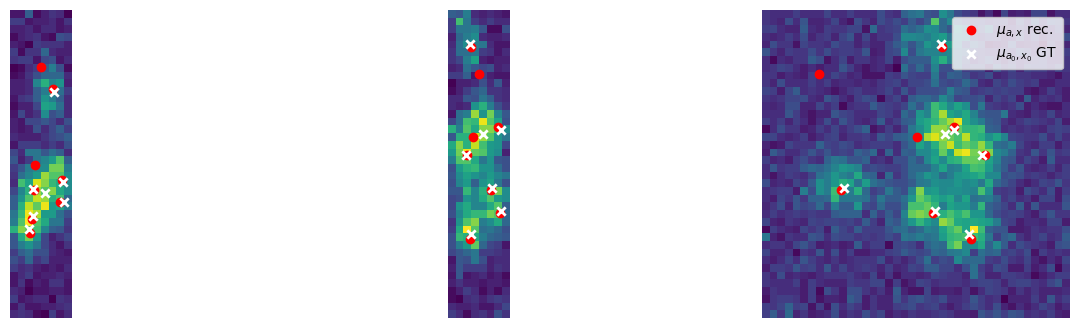

In [33]:
plt.figure(figsize=(16, 4))
for i in range(3): 
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.amax(y[:, :, :], axis=i))
    
    scatter_red = plt.scatter(
        m_sfw_L2.x[:, 2] / pixel_size_z + N_z / 2 if i != 2 else m_sfw_L2.x[:, 0] / pixel_size_xy + N_xy / 2,
        m_sfw_L2.x[:, 0] / pixel_size_xy + N_xy / 2 if i == 0 else m_sfw_L2.x[:, 1] / pixel_size_xy + N_xy / 2,
        c='red', label=r'$\mu_{a,x}$ rec.')
    
    scatter_white = plt.scatter(
        m_ax0.x[:, 2] / pixel_size_z + N_z / 2 if i != 2 else m_ax0.x[:, 0] / pixel_size_xy + N_xy / 2,
        m_ax0.x[:, 0] / pixel_size_xy + N_xy / 2 if i == 0 else m_ax0.x[:, 1] / pixel_size_xy + N_xy / 2,
        marker='x', color='white', label=r'$\mu_{a_0,x_0}$ GT', linewidths=2)
    
    if i == 2:
        plt.legend(loc='best', fontsize=10)
        
    plt.axis('off')

plt.show()


In [13]:
# q_xy = 10 # super-resolution factor
# q_z = 5
# sigma_q_xy = sigma/q_xy
# sigma_q_z = sigma_z/q_z

# X_big,Y_big,Z_big = np.meshgrid(np.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy*q_xy),
#                    np.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy*q_xy),
#                    np.linspace(-sizeGrid_z/2,sizeGrid_z/2, N_z*q_z))
# rec_L2 = m_sfw_L2.kernel(X_big,Y_big,Z_big, sigma_q_xy, sigma_q_xy, sigma_q_z)

# plt.figure(figsize=(16, 4))
# for i in range(3): 
#     plt.subplot(1,3,i+1)
#     plt.imshow(np.amax(rec_L2[:,:,:],axis=i))
# plt.show()

In [36]:
tol = 3*pixel_size_xy
jaccard_L2, TP_L2, FN_L2, FP_L2, RMSE_ampl_L2, RMSE_pos_L2 = jaccard_rmse(m_ax0, m_sfw_L2, tol)
jaccard_L2, TP_L2, FN_L2, FP_L2, RMSE_ampl_L2, RMSE_pos_L2

(0.6666666666666666, 6, 1, 2, 1.3025321306791144, 67.9313957415253)

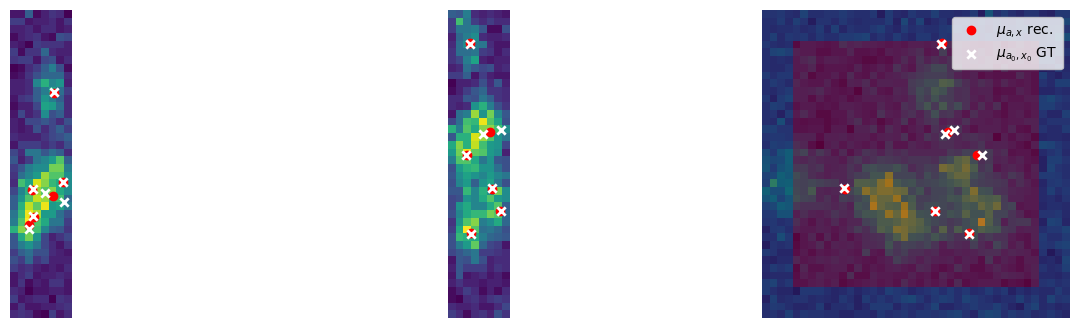

In [37]:

# Parametri per definire il margine
margin = 4  # Numero di pixel nella corona esterna
N_z, N_xy = y.shape[2], y.shape[0]  # Dimensioni del volume

# Creazione della maschera binaria per la corona esterna
background_mask = np.zeros((N_xy, N_xy), dtype=int)
background_mask[:margin, :] = 1  # Parte superiore
background_mask[-margin:, :] = 1  # Parte inferiore
background_mask[:, :margin] = 1  # Parte sinistra
background_mask[:, -margin:] = 1  # Parte destra

# Visualizzazione delle proiezioni 2D con la maschera evidenziata
plt.figure(figsize=(16, 4))
for i in range(3): 
    plt.subplot(1, 3, i + 1)
    
    # Calcolo della proiezione massima lungo l'asse i
    projection = np.amax(y, axis=i)
    if i == 2:  # Transponi per mantenere l'orientamento corretto
        projection = projection.T
        mask = background_mask.T
    
    # Mostra la proiezione
    plt.imshow(projection, cmap='viridis')
    
    if i==2:
        # Sovrapponi la maschera
        plt.imshow(mask, alpha=0.5, cmap='RdBu')
    
    # Aggiungi i punti rossi e bianchi
    scatter_red = plt.scatter(
        m_sfw_KL.x[:, 2] / pixel_size_z + N_z / 2 if i != 2 else m_sfw_KL.x[:, 0] / pixel_size_xy + N_xy / 2,
        m_sfw_KL.x[:, 0] / pixel_size_xy + N_xy / 2 if i == 0 else m_sfw_KL.x[:, 1] / pixel_size_xy + N_xy / 2,
        c='red', label=r'$\mu_{a,x}$ rec.')
    
    scatter_white = plt.scatter(
        m_ax0.x[:, 2] / pixel_size_z + N_z / 2 if i != 2 else m_ax0.x[:, 0] / pixel_size_xy + N_xy / 2,
        m_ax0.x[:, 0] / pixel_size_xy + N_xy / 2 if i == 0 else m_ax0.x[:, 1] / pixel_size_xy + N_xy / 2,
        marker='x', color='white', label=r'$\mu_{a_0,x_0}$ GT', linewidths=2)
    
    if i == 2:
        plt.legend(loc='best', fontsize=10)
        
    plt.axis('off')

plt.show()
